In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading and Cleaning
Todo
* save cleaned dataset

In [40]:
df = pd.read_csv('data/df_audio_features_1000')
df = (df
    .assign(song_artist = df['name'] + " by " + df['artist'] + "(" + df['id'] + ")")
    .drop(columns='type')
    .dropna()
    .drop_duplicates()
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1439
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1434 non-null   object 
 1   artist            1434 non-null   object 
 2   danceability      1434 non-null   float64
 3   energy            1434 non-null   float64
 4   key               1434 non-null   int64  
 5   loudness          1434 non-null   float64
 6   mode              1434 non-null   int64  
 7   speechiness       1434 non-null   float64
 8   acousticness      1434 non-null   float64
 9   instrumentalness  1434 non-null   float64
 10  liveness          1434 non-null   float64
 11  valence           1434 non-null   float64
 12  tempo             1434 non-null   float64
 13  duration_ms       1434 non-null   int64  
 14  time_signature    1434 non-null   int64  
 15  id                1434 non-null   object 
 16  html              1434 non-null   object 


# Pre-processing
Todo
* different scalers

In [79]:
from src.proj4_utils import test_num_data_scale

# min max values of features that are not within [0,1] according to
# https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features
from sys import maxsize as sys_maxsize
scale_dict = {'key' : (-1, 11), 
              'loudness' : (-60, 0), 
              'time_signature' : (3, 7), 
              'duration_ms' : (0, sys_maxsize), 
              'tempo' : (0, sys_maxsize),
              'default' : (0, 1)}

from src.utils import get_numerical_columns
df_num = df[get_numerical_columns(df)]
#test_num_data_scale(df_num, scale_dict)  #<<<<<------------test scaling

# set a priori knowledge min/max for proper fitting of the scaler
# instead of using at hand values that might not extend well to future data
df_num_minmax = df_num.describe().loc[['min', 'max'],:]
scale_dict.pop('default', None)
df_num_minmax.loc[:,scale_dict.keys()] = pd.DataFrame(
                                            data = scale_dict, 
                                            columns = scale_dict.keys(), 
                                            index = df_num_minmax.index)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_num_minmax)

# apply the scaler
df_num_scaled = pd.DataFrame(scaler.transform(df_num), columns=df_num.columns, index=df_num.index)

In [42]:
df_num_scaled.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1.434000e+03,1.434000e+03,1434.000000
mean,0.529702,0.496230,0.513192,0.814870,0.662483,0.113876,0.471413,0.192057,0.159561,0.469110,1.248972e-17,3.162551e-14,0.222455
std,0.242552,0.283048,0.295339,0.116463,0.473028,0.155390,0.376077,0.342248,0.151639,0.298362,3.426436e-18,2.476664e-14,0.111802
min,0.000000,0.000000,0.083333,0.259900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.387292e-18,6.804236e-15,-0.500000
25%,0.360902,0.244212,0.250000,0.750437,0.000000,0.027496,0.083206,0.000000,0.072617,0.201626,9.866755e-18,2.094570e-14,0.250000
50%,0.555506,0.531617,0.500000,0.851008,1.000000,0.045224,0.420681,0.000130,0.100902,0.473275,1.192091e-17,2.534735e-14,0.250000
75%,0.719980,0.735938,0.750000,0.905338,1.000000,0.118804,0.872490,0.165228,0.189049,0.725502,1.469457e-17,3.348339e-14,0.250000
max,1.000000,1.000000,1.000000,1.018083,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.236850e-17,4.137085e-13,0.500000


In [43]:
from sklearn.metrics import pairwise_distances

# metric = ['euclidean', 'manhatten']
def get_distances(df, metric = 'euclidean', labels = None):
    if labels is not None:
        df = df.copy().set_index(labels)
    return pd.DataFrame(pairwise_distances(df, metric = metric), index=df.index, columns=df.index)

# Euclidean (by default)
ecl_dis = get_distances(df_num_scaled, labels = df['song_artist'])

# K-Means

TODO
* automatic selection of number of clusters via inertia & silhouette score

In [80]:
from sklearn.cluster import KMeans

# from scatter plot we can see shit, 
# we are going to assume there can be num_clusters different clusters.
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_num_scaled)

KMeans(n_clusters=7)

In [91]:
cl_pos = pd.DataFrame(kmeans.cluster_centers_)
num_cols = list(df_num_scaled.columns)
cl_pos.columns = num_cols
df_res = df_num_scaled.copy()
df_res['clusters'] = kmeans.labels_
df_res['id'] = df.loc[:,'id']

In [82]:
df_res.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1439
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1434 non-null   float64
 1   energy            1434 non-null   float64
 2   key               1434 non-null   float64
 3   loudness          1434 non-null   float64
 4   mode              1434 non-null   float64
 5   speechiness       1434 non-null   float64
 6   acousticness      1434 non-null   float64
 7   instrumentalness  1434 non-null   float64
 8   liveness          1434 non-null   float64
 9   valence           1434 non-null   float64
 10  tempo             1434 non-null   float64
 11  duration_ms       1434 non-null   float64
 12  time_signature    1434 non-null   float64
 13  clusters          1434 non-null   int32  
 14  id                1434 non-null   object 
dtypes: float64(13), int32(1), object(1)
memory usage: 173.6+ KB


# Visualising Results
Todo
* 

Text(0.5, 1.0, 'Looking for a relation between features')

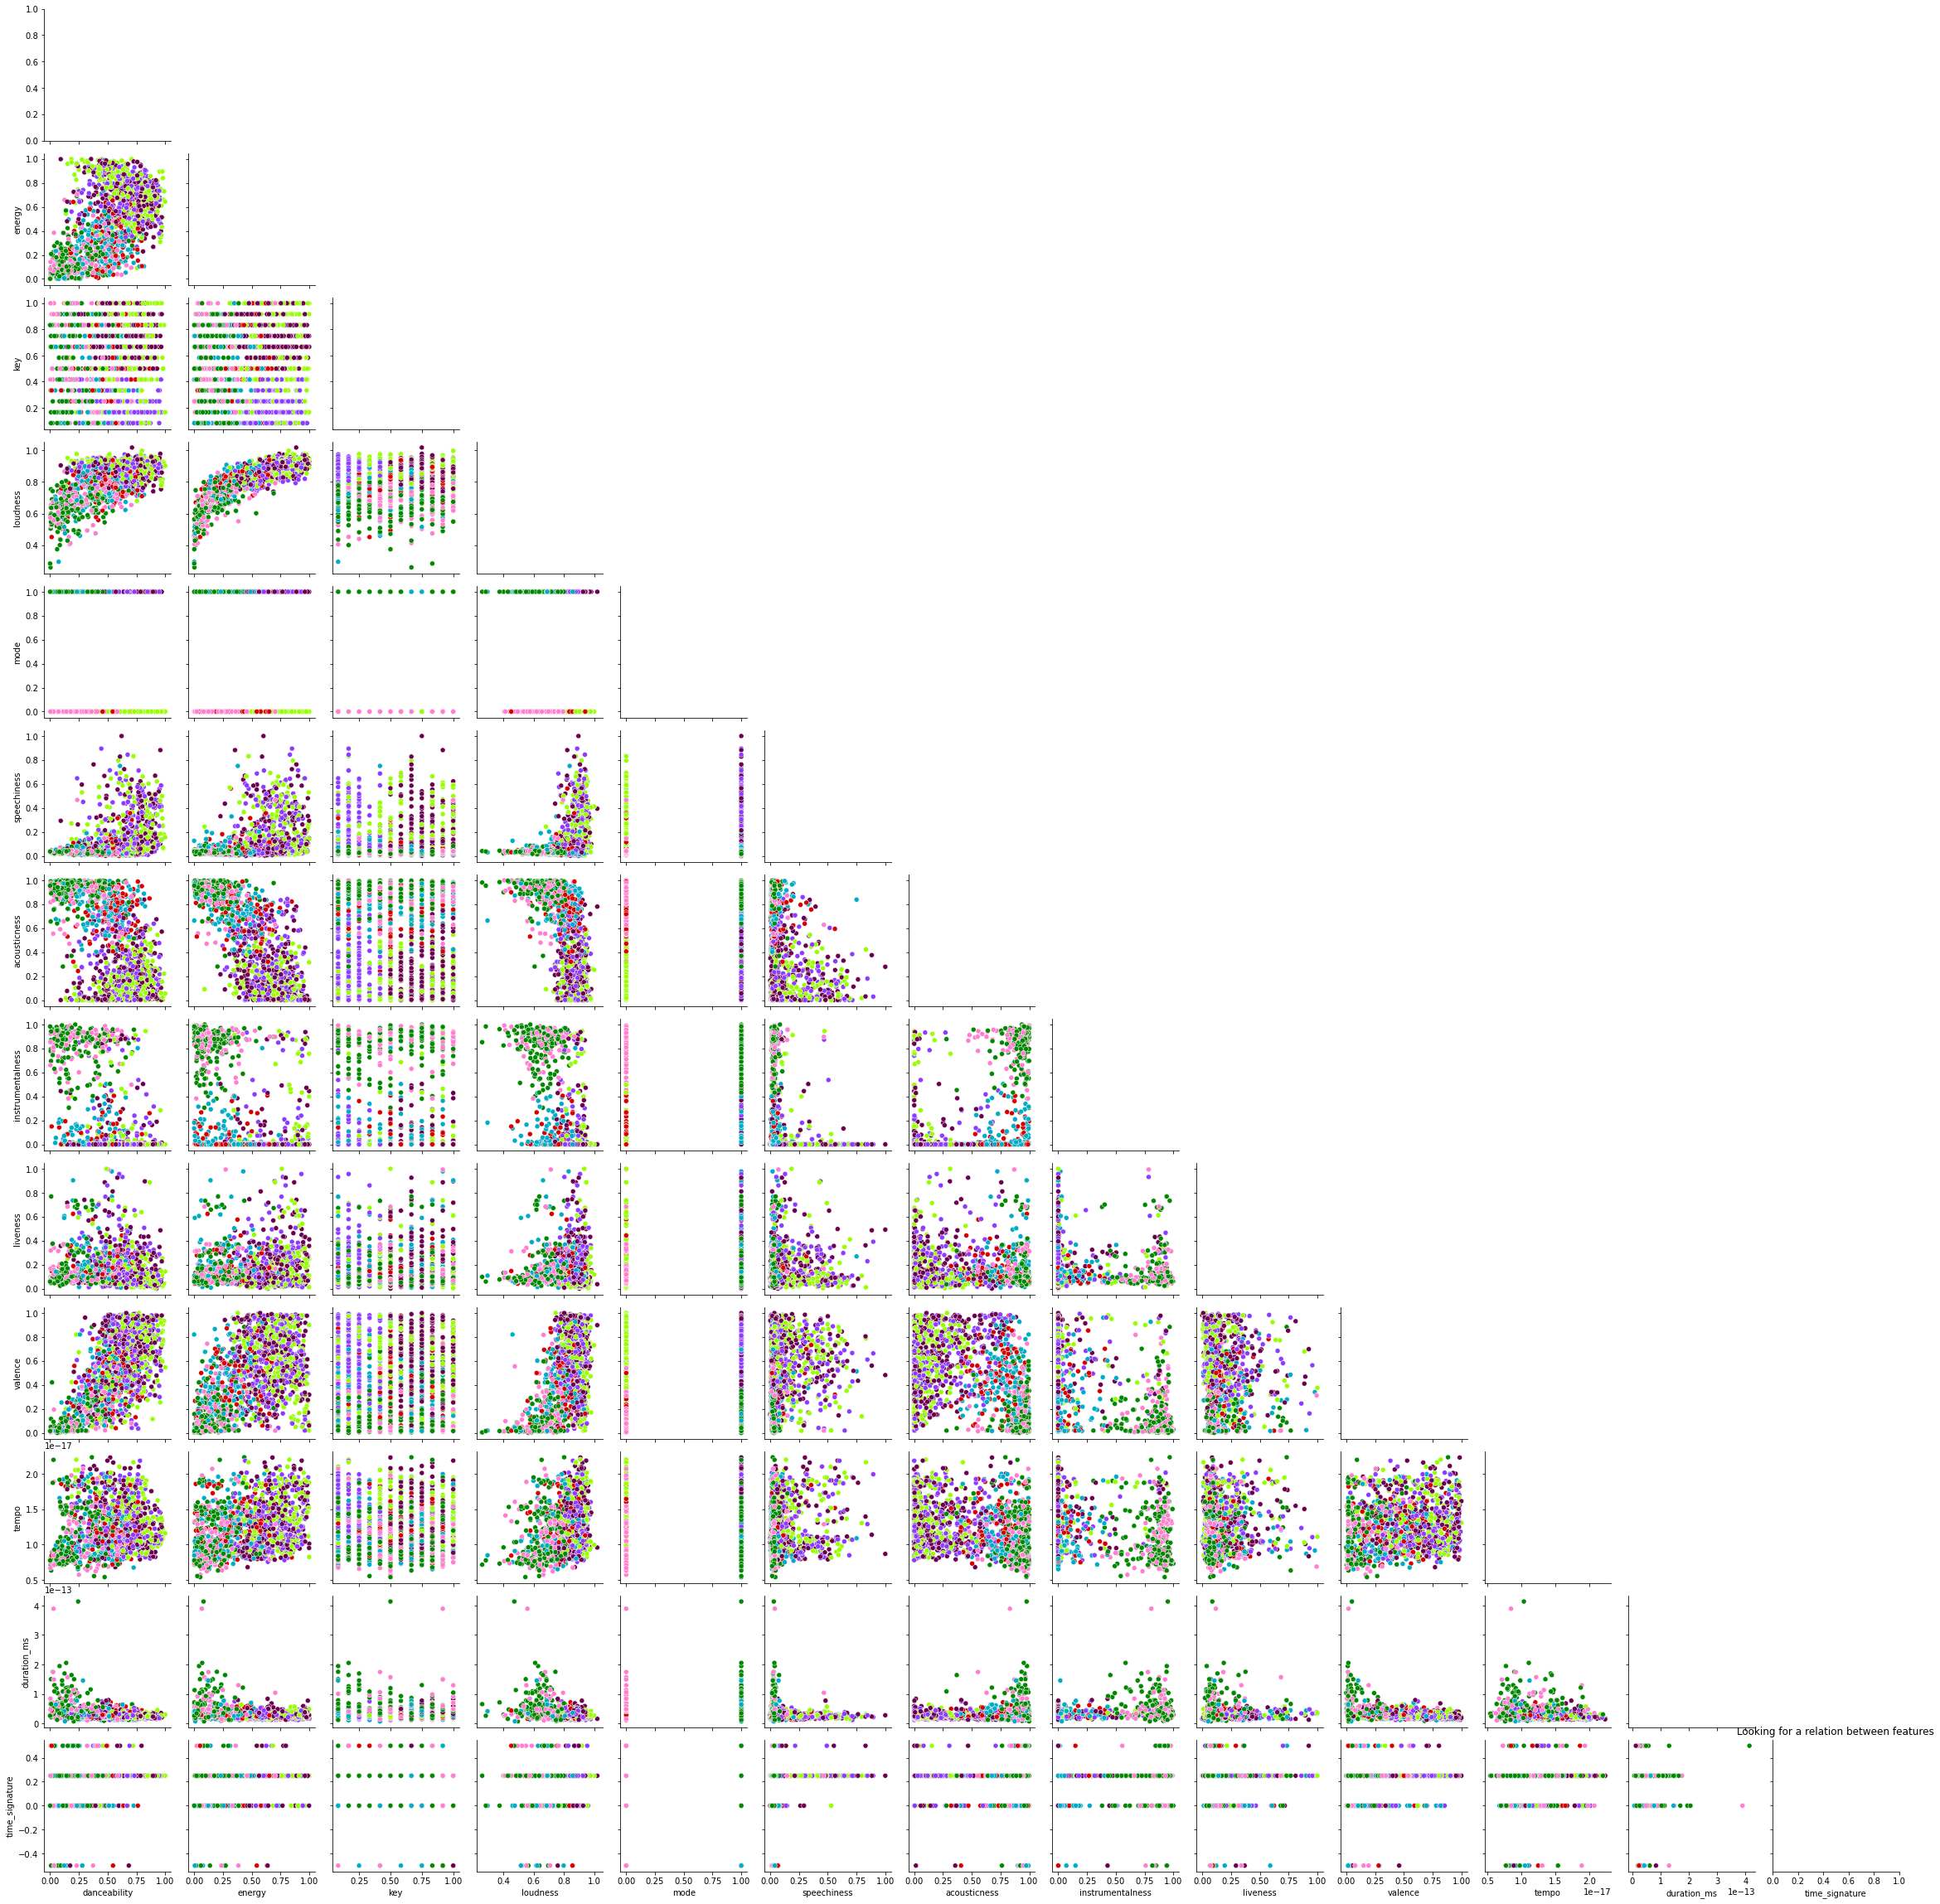

In [96]:
from src.utils import install_pip_pkg
install_pip_pkg({'colorcet'})
import colorcet as cc
import seaborn as sns

# retrospective pairwise scatterplots of all features with clusters as hue
palette = sns.color_palette(cc.glasbey, n_colors=num_clusters)
g = sns.PairGrid(df_res[num_cols + ['clusters']], hue='clusters', palette = palette, corner=True)
g.map_lower(sns.scatterplot)
plt.title('Looking for a relation between features')

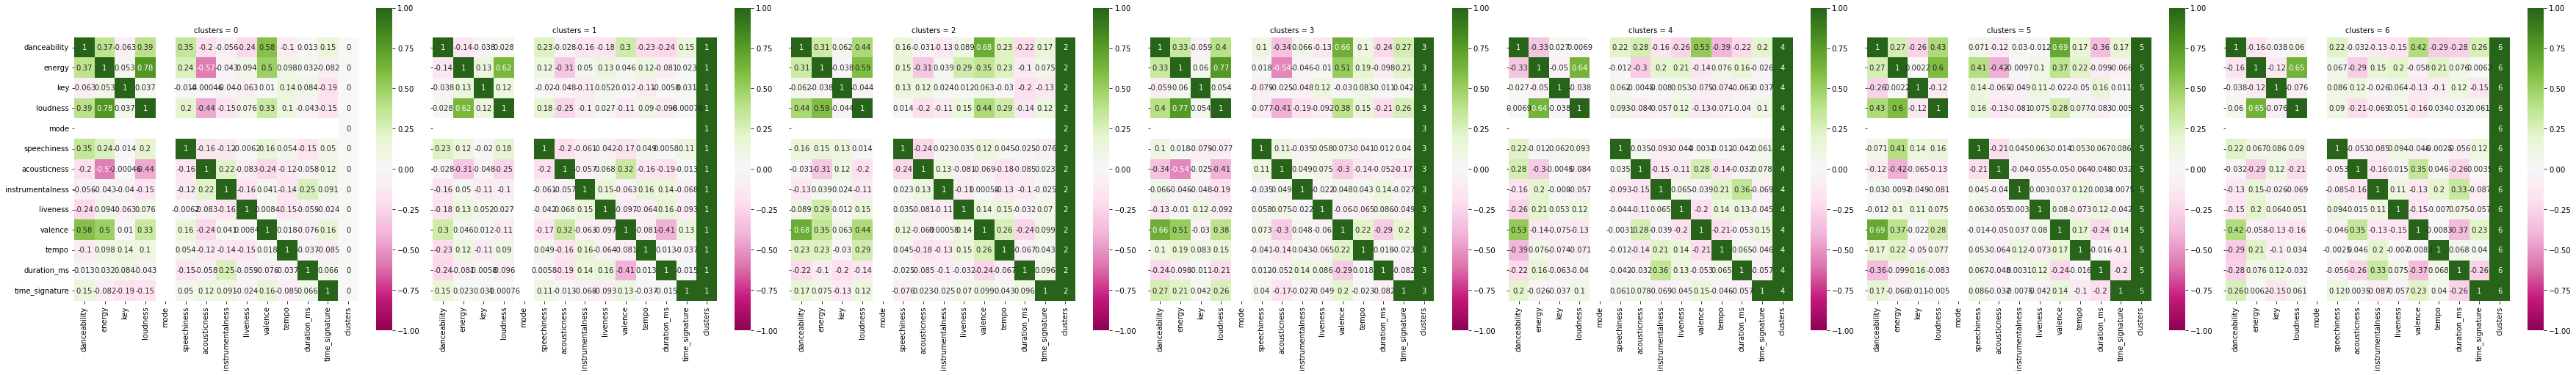

In [94]:
from src.visualisations import corr_heatmap
df_corr_data = corr_heatmap(df_res[num_cols + ['clusters']])

In [95]:
for i in range(num_clusters):
    print(df_corr_data.loc[df_corr_data['clusters'] == i, ['clusters', 'sum']].sort_values(by='sum', ascending=False))

                  clusters       sum
valence                  0  2.493334
energy                   0  2.466088
danceability             0  2.180864
loudness                 0  2.130575
speechiness              0  1.613996
time_signature           0  1.106764
duration_ms              0  1.020190
key                      0  0.948502
instrumentalness         0  0.890676
tempo                    0  0.769761
liveness                 0  0.388405
mode                     0  0.000000
acousticness             0 -0.533770
                  clusters       sum
energy                   1  1.707227
loudness                 1  1.515942
time_signature           1  1.215118
speechiness              1  1.205936
liveness                 1  1.119211
key                      1  1.016298
instrumentalness         1  0.886180
valence                  1  0.873885
tempo                    1  0.758550
danceability             1  0.698803
duration_ms              1  0.294916
acousticness             1  0.129314
m

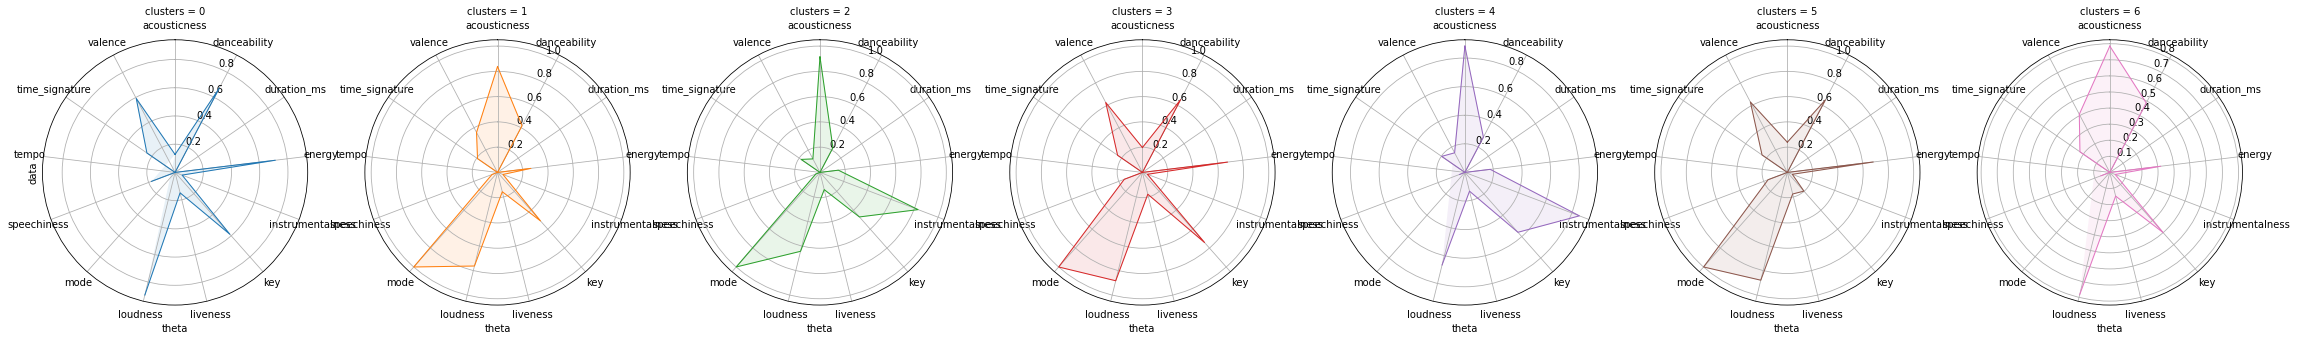

In [101]:
from src.visualisations import spider_plot
spider_plot(cl_pos)

# Metrics
Todo
* compare to myJam dataset
* get playlists from Spotify API and count in-cluster-songs occurences


In [8]:
import requests
from src.utils import ConfigHandler

config_handler = ConfigHandler('.env_spotify')
client_keys = config_handler.load_config('spotify')
CLIENT_ID = client_keys['client_id']
CLIENT_SECRET = client_keys['client_secret']
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']


In [9]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URI
track_id = '6y0igZArWVi6Iz0rj35c1Y'

# actual GET request with proper header
r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)

In [10]:
r

<Response [200]>

In [7]:
class SpotifyHandler():
    
    def __init__(self, env_file_path):
        self.__sp = self.setup_spotify_connection(env_file_path)
        
    def setup_spotify_connection(self, env_file_path):
        from src.utils import install_pip_pkg
        install_pip_pkg({'spotipy'})

        # import libraries
        import spotipy
        from spotipy.oauth2 import SpotifyClientCredentials
        from src.utils import ConfigHandler

        #Initialize SpotiPy with user credentias
        config_handler = ConfigHandler(env_file_path)
        client_keys = config_handler.load_config('spotify')
        sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
            client_id = client_keys['client_id'], client_secret = client_keys['client_secret']))
        return sp
    
    def get_connection(self):
        return self.__sp
    
    def retrieve_tracks(self, cluster_song_id_list):   
        # regarding ids : a list of spotify URIs, URLs or IDs. Maximum: 50 IDs.
        # install flatdict
        from src.utils import install_pip_pkg
        install_pip_pkg({'flatdict'})
        from flatdict import FlatterDict as flatten
        from pandas import json_normalize as pd_json_normalize
        song_list = self.retrieve_bits_for_tracks(cluster_song_id_list, self.__sp.tracks, market=None)
        df_songs = pd_json_normalize([dict(flatten(i)) for i in song_list[0]['tracks']])
        return df_songs
    
    def retrieve_artists_from_songs(self, cluster_song_id_list, return_all = 'no'):  
        # regarding ids : a list of spotify URIs, URLs or IDs. Maximum: 50 IDs.
        df_songs = self.retrieve_tracks(cluster_song_id_list)
        srs_artist_ids = df_songs['album:artists:0:id']
        
        response = self.retrieve(self.__sp.artists, srs_artist_ids)            
        df_artists = pd.json_normalize(response['artists'])
        
        if return_all == 'no':
            return df_artists
        else:
            return df_songs, df_artists
    
    def retrieve_genre_from_songs(self, cluster_song_id_list, return_all = 'no'):
        df_songs, df_artists = self.retrieve_artists_from_songs(cluster_song_id_list, return_all = 'yes')
        df_songs['artist_genres'] = df_artists[['genres']]
        
        if return_all == 'no':
            return df_songs
        else:
            return df_songs, df_artists
        
    def retrieve_bits_for_tracks(self, cluster_song_id_list, func, **kwargs):        
        # retrieving tracks
        # regarding ids : a list of spotify URIs, URLs or IDs. Maximum: 50 IDs.
        song_list = []
        id_list_len = len(cluster_song_id_list)
        step = 50
        for lower in list(range(0, id_list_len, step)) + [id_list_len % step]:
            upper = min(id_list_len - lower, 50)
            
            response = self.retrieve(func, cluster_song_id_list[lower:upper], **kwargs) 
            song_list.append(response)
        return song_list
    
    def retrieve(self, func, *args, **kwargs):
        from spotipy.client import SpotifyException
        
        response = None
        try:
            response = func(*args, **kwargs)
        except SpotifyException as error:
            print(repr(error))
            print(error.http_status)
            print(error.reason)            
            print(error.headers)
        return response
            
        
def metric_compare_genre(sp_handler, cluster_song_id_list):
    return sp_handler.retrieve_genre_from_songs(cluster_song_id_list)

sp_handler = SpotifyHandler('.env_spotify')

df_res = pd.read_csv('data/data_cleaned_clustered.csv') #data/df_audio_features_1000')
df_res.rename(columns = {'cluster' : 'clusters'}, inplace=True)
num_clusters = df_res['clusters'].nunique()

from src.utils import load_csv_or_execute
genre_path = 'data/genres'

df_song_list = []
for i in range(num_clusters):
    mask = df_res['clusters'] == i
    selected_songs = df_res.loc[mask,:].nlargest(n = 100, columns='dist2centroid', keep='all')[['id']]
    data = load_csv_or_execute(
                        f'{genre_path}_cluster{i}.csv', 
                        metric_compare_genre, 
                        {'sp_handler' : sp_handler, 'cluster_song_id_list' : selected_songs})
    
    df_song_list.append(data)

Max Retries reached


SpotifyException(429, -1, '/v1/tracks/?ids=id:\n Max Retries')
429
too many 502 error responses
{}


Max Retries reached


SpotifyException(429, -1, '/v1/tracks/?ids=id:\n Max Retries')
429
too many 502 error responses
{}


Max Retries reached


SpotifyException(429, -1, '/v1/tracks/?ids=id:\n Max Retries')
429
too many 502 error responses
{}


TypeError: 'NoneType' object is not subscriptable

In [14]:
df_res

,id,name,artist,dance,energy,loud,speech,acoustic,instrument,live,valence,tempo,cluster,dist2centroid
0,1n7JnwviZ7zf0LR1tcGFq7,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658714,0.249164,0.320430,0.127597,0.697487,0.000060,0.987706,0.294839,0.420037,4,0.859888
1,5QGM1U0eCYrQuwSJwTm5Zq,Saudade De Bahia ...,Antônio Carlos Jobim,0.751491,0.391022,0.343656,0.031966,0.218090,0.000002,0.098453,0.696749,0.527017,1,0.479181
2,0NLIFSZxPzQhCwnkn5PJYs,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.871880,0.726416,0.418637,0.864145,0.455276,0.000065,0.115869,0.916918,0.298357,1,0.836504
3,3mXqOdlLE1k67WsAxryPFs,Mulher Eu Sei ...,Chico César,0.710625,0.037592,0.087040,0.065264,0.883417,0.000041,0.384284,0.521238,0.393962,4,0.563624
4,7bSzjzjTkWT2CkIPPdp0eA,Rosa Morena ...,Kurt Elling,0.650983,0.107306,0.007648,0.041023,0.920603,0.000351,0.095380,0.394537,0.497118,4,0.541073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4656,0lMDzAcO0RPdj30zcqUEU9,Sinfonia: III. In ruhig fliessender Bewegung ...,Luciano Berio,0.230175,0.246124,0.050441,0.120938,0.864322,0.154397,0.371991,0.157753,0.221429,4,0.667891
4657,2T1bhzjTfir3gsLRiudU1e,"Elgar: Enigma Variations, Op. 36: XV. EDU (Fin...",Edward Elgar,0.093218,0.243084,0.073292,0.045818,0.888442,0.916155,0.088516,0.118289,0.201037,0,0.383872
4658,3SOZcwfezNCWKs2vukSELD,"Also sprach Zarathustra, Op.30, TrV 176: Prelu...",Richard Strauss,0.058979,0.291722,0.311984,0.059403,0.640201,0.956033,0.146604,0.019524,0.178544,0,0.536500
4659,6VZ0CYMRhrdprO6u9rMwxC,"Symphony No. 3 - ""Chant de la nuit"", Op. 27: L...",Karol Szymanowski,0.047935,0.220792,0.059309,0.077251,0.676382,0.054499,0.149677,0.013189,0.280074,4,0.776726


In [33]:
df_song_list[0].columns.tolist() #[['album:artists:0:name', 'artist_genres']]

IndexError: list index out of range

In [55]:
sp_handler.get_connection().get_auth_response()

AttributeError: 'Spotify' object has no attribute 'get_auth_response'

In [ ]:
def metric_compare_myjam():
    pass

In [ ]:
def metric_compare_playlists():
    pass

# Finalise Playlists
Todo
* answer: 
    * are Spotify’s audio features able to identify “similar songs”, as defined by humanly detectable criteria?
    * is K-Means a good method to create playlists?  ->no: "similar" != "playlist-member"


In [83]:
# return the n closest songs to a cluster
# song identifier has to be in the index
# metric = ['euclidean', 'cityblock']; for more see
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
def get_top_songs(n, df_songs, df_cluster, num_cols, metric = 'euclidean'):
    from scipy.spatial.distance import cdist
    from pandas import DataFrame as pd_dataframe
    
    distance_list = []
    for i in range(df_cluster.shape[0]):
        mask = df_songs['clusters'] == i
        distance_list.extend(cdist(df_songs.loc[mask,num_cols], df_cluster.iloc[i, :].to_frame().T, metric))

    return pd_dataframe(
                    data = distance_list,
                    index = df_songs.index,
                    columns = ['distance']
            )
    
df_res['distance'] = get_top_songs(10, df_res, cl_pos, num_cols)

In [84]:
df_res

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters,id,distance
0,0.624060,0.469869,0.916667,0.797300,1.0,0.196816,0.884538,0.000006,0.127865,0.965817,8.038166e-18,1.269384e-14,0.25,6,5ueyLj6e6oVaTY0KQ6yLaA,0.299747
1,0.580938,0.247977,0.166667,0.789800,1.0,0.030391,0.453814,0.000009,0.089495,0.591879,1.378563e-17,2.426011e-14,0.25,1,3aEJMh1cXKEjgh52claxQp,0.801731
2,0.254755,0.227896,0.333333,0.782333,1.0,0.014291,0.947791,0.000081,0.618376,0.211726,1.239005e-17,1.705374e-14,0.25,3,307XEC1IUwUs9ojlEFwH7f,0.389452
3,0.531181,0.683728,0.416667,0.909333,1.0,0.049928,0.811245,0.000000,0.146531,0.802155,9.582721e-18,3.329075e-14,0.25,3,5yQ9iMZXGcr5rlO4hoLsP4,0.588397
4,0.437196,0.167654,0.083333,0.773117,1.0,0.091715,0.921687,0.000000,0.157938,0.398177,8.252730e-18,2.006500e-14,0.25,3,3vFVS2WYHDG4KkWCNecvpn,0.522068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.157452,0.069660,0.333333,0.610167,1.0,0.043596,0.920683,0.725888,0.064814,0.047545,9.530788e-18,1.078781e-13,0.25,2,1aEhYlZtypmipA06SDJ4U3,0.567930
1436,0.141973,0.101387,0.583333,0.635450,1.0,0.037988,0.858433,0.432487,0.050503,0.016470,9.013406e-18,9.269929e-14,0.25,2,1Gfqe7TAKklmuZf6hxsH6h,0.658650
1437,0.000000,0.000913,0.833333,0.284017,1.0,0.036541,0.954819,0.983756,0.058592,0.015330,7.759960e-18,2.582429e-14,0.00,2,2XNwnFrdMDpismp0VUZ7cU,0.496137
1438,0.081159,0.020864,0.416667,0.509283,1.0,0.033828,0.886546,0.512690,0.093643,0.040916,7.275972e-18,3.407723e-14,0.25,2,7ucDwgMtE3YJtEfTbuRhy0,0.708525
